In this script we analyze our target convolutional neural network in order to understand the features it computes and stores in its first convolutional layer activations.

The code imports libraries for neural networks such as (`torch`), neural network layers (`torch.nn`), optimization algorithms (`torch.optim`), and image processing tools (`torchvision`). Additionally, it imports Matplotlib for data visualization and NumPy for numerical operations.

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

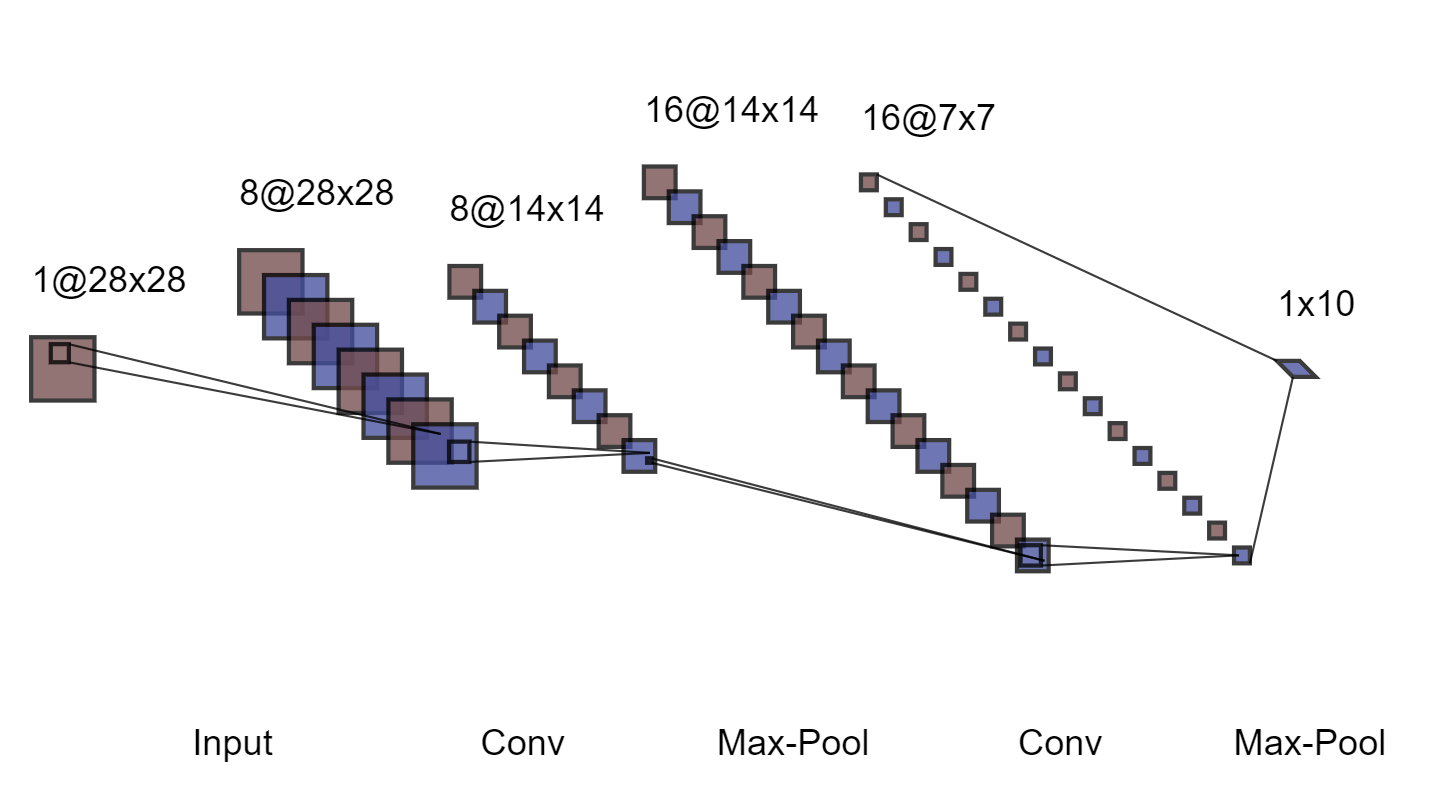

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = self._init_conv_layer(1, 8, 9, 1, 4, 'he')
        self.conv2 = self._init_conv_layer(8, 16, 9, 1, 4, 'he')
        self.out = nn.Linear(16 * 7 * 7, 10)
        nn.init.kaiming_normal_(self.out.weight, nonlinearity='relu')

    def _init_conv_layer(self, in_channels, out_channels, kernel_size, stride, padding, init_method):
        """Initializes a convolutional layer followed by a ReLU activation and MaxPool."""
        layer = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        if init_method == 'he':
            nn.init.kaiming_normal_(layer[0].weight, nonlinearity='relu')

        return layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)

        output = self.out(x)
        return output, x


We begin by initializing our convolutional neural network. To train this model, we will need to measure how well it's performing. We do this using what's known as a loss function, and in this case, we're utilizing the CrossEntropyLoss, a common choice for classification problems.

To improve our model, we use an optimizer that adjusts the model's parameters based on the loss. Here, we're using the Adam optimizer, a popular choice for its balance of efficiency and effectiveness, with a learning rate of 0.001.

The next step is data preprocessing. Since we're working with the MNIST dataset, which consists of grayscale images, we need to transform these images into a format that our model can work with. We apply a composition of transformations — first, converting images to tensors, and then normalizing them with a mean and standard deviation of 0.5. This normalization helps in stabilizing the learning process and leads to faster convergence.

With our data ready, we wrap it in DataLoader objects. These will handle the shuffling and batching of the dataset during training, making our training process more efficient.

Finally, we start the training loop. For each epoch — that is, one pass through the entire dataset — we iterate over the training data in batches. For each batch, we perform a forward pass through the model to get the predictions, calculate the loss, and then update the model's parameters by backpropagating the gradients and stepping the optimizer.

After each epoch, we print a message to indicate the completion of that epoch. This not only informs us about the training progress but also adds checkpoints to observe the model's performance over time.

By the end of the last epoch, our model will have learned patterns specific to the MNIST dataset, ready to be evaluated on unseen data.

In [ ]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Data Preprocessing and Loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

num_epochs = 10

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        outputs, _ = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}] completed.')


The training itself was done in another script, so we just upload the weights here.

In [ ]:
from google.colab import files

uploaded = files.upload()

# Check what files have been uploaded
print("Uploaded files:", uploaded.keys())

# If there are multiple files, you can loop through the keys or just pick the one you need
file_name = list(uploaded.keys())[0]

with open(file_name, 'wb') as f:
    f.write(uploaded[file_name])
model = CNN()
model.load_state_dict(torch.load(file_name))


Saving mnistTwoLayersFilterSize9And16Filters.pth to mnistTwoLayersFilterSize9And16Filters.pth
Uploaded files: dict_keys(['mnistTwoLayersFilterSize9And16Filters.pth'])


<All keys matched successfully>

In order to check whether our parameters are the correct ones, we evaluate the model on the test data set.

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs, _ = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy of the model: {test_accuracy}%')


Test Accuracy of the model: 98.85%


To ensure consistency, we set a fixed seed for the random number generator. We then sample four indices from the MNIST test dataset and retrieve the corresponding images and labels. These images are prepared to be input into the neural network, and displayed for illustration

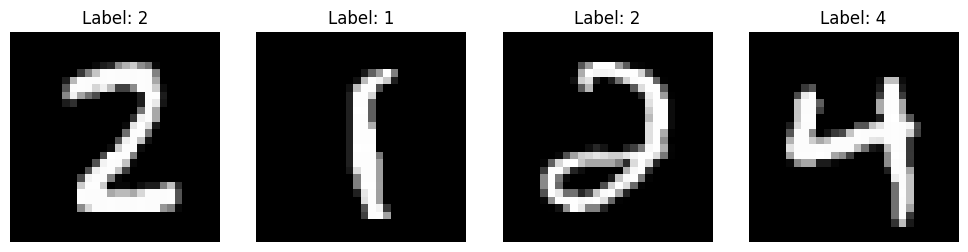

In [ ]:
import random

seed_value = 42
random.seed(seed_value)
torch.manual_seed(seed_value)

indices = random.sample(range(len(test_dataset)), 5)
random_images = [test_dataset[i][0] for i in indices]
random_labels = [test_dataset[i][1] for i in indices]
random_images_stacked = torch.stack(random_images)

# Create a 1x4 grid for plotting, since you want 4 images in one row
fig, axes = plt.subplots(1, 4, figsize=(10, 2.5))  # Adjust the figsize as needed

# Plot each of the 4 images
for i in range(4):
    img = random_images[i].squeeze()  # Squeeze to remove any extra dimensions
    label = random_labels[i]
    axes[i].imshow(img, cmap='gray')  # Assuming the images are in grayscale
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

For the weight visualization analysis, we visualize the weights of the model's first convolutional layer. It does so by first accessing the weight tensor, ensuring no gradients are computed during the process with torch.no_grad(). The weights are then transferred to the CPU and converted into a NumPy array. We take the absolute value of these weights, as the magnitude of the weights is typically of interest, rather than the sign.

The visualization arranges the filters into a 2x4 grid, corresponding to the eight filters of the first convolutional layer. Each filter's weights are displayed as a grayscale image, where the pattern of weights can give us insight into what features each filter might be responding to. After preparing all subplots, the function displays the grid of weight patterns.

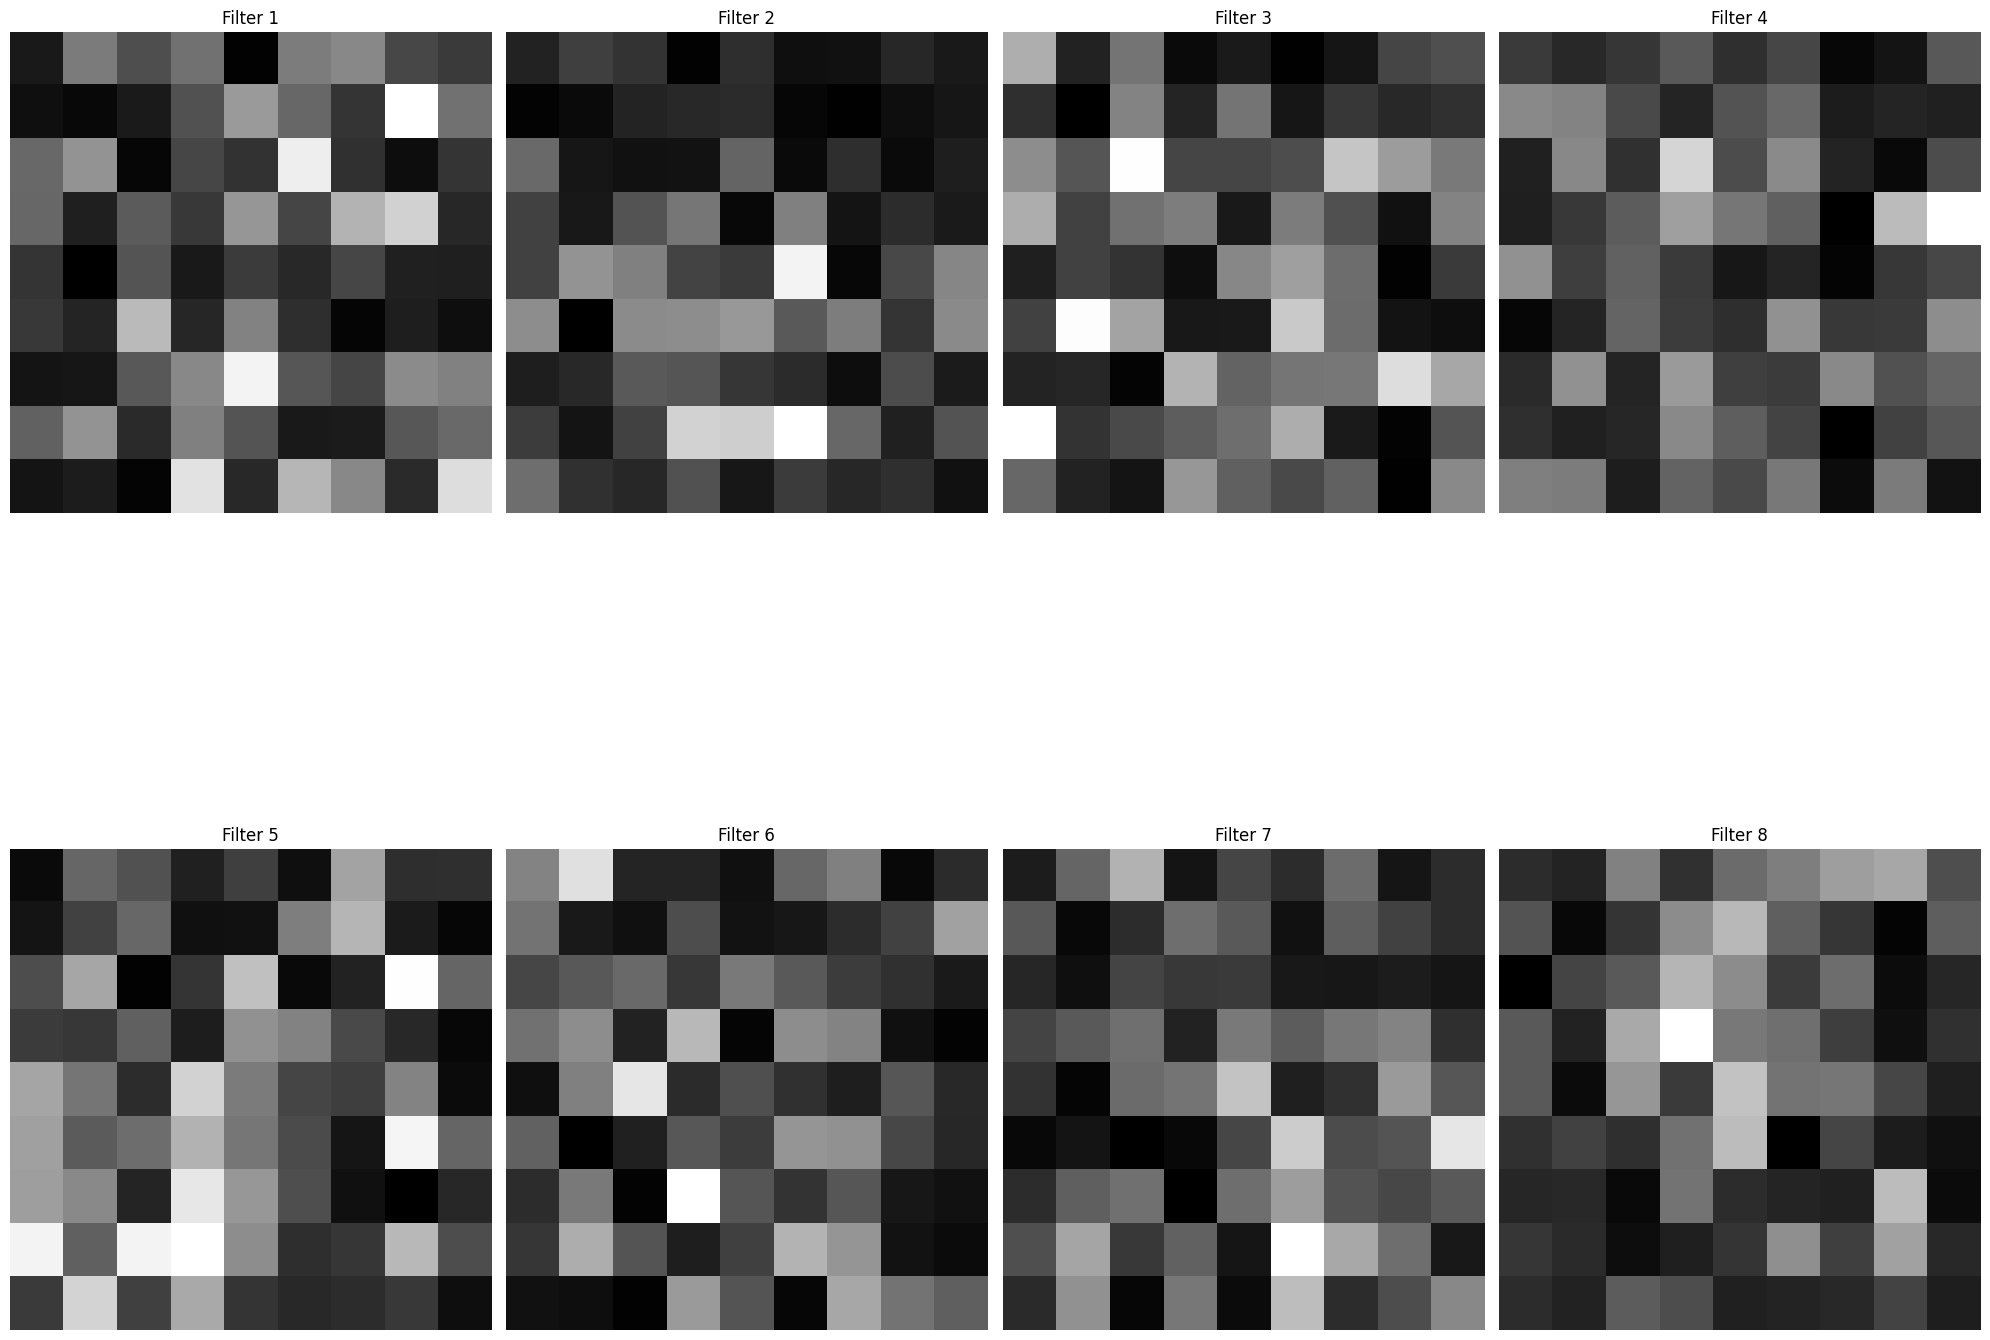

In [ ]:
def visualize_weights(model):
    with torch.no_grad():
        weight_tensor = model.conv1[0].weight.cpu()
        weight_arr = np.abs(weight_tensor.numpy())

        num_filters = weight_arr.shape[0]
        fig, axes = plt.subplots(2, 4, figsize=(20, 20))

        for i in range(num_filters):
            row = i // 4
            col = i % 4
            axes[row, col].imshow(weight_arr[i, 0], cmap='gray')
            axes[row, col].set_title(f'Filter {i+1}')
            axes[row, col].axis('off')
        plt.subplots_adjust(wspace=0.1, hspace=0.1)


        plt.tight_layout()
        plt.show()


visualize_weights(model)


When an input image passes through the CNN's filters, they produce activation maps that highlight specific features, such as edges or textures. We visualize these maps which helps understand how the filters collectively interpret and process visual information, offering insights into the model's feature extraction process. By comparing the activation maps with the original images, we gain clarity on the distinct roles of each filter in the layer. For instance, some filters activate strongly on edges or corners, while others respond to more complex patterns or even specific shapes or orientations within the image.


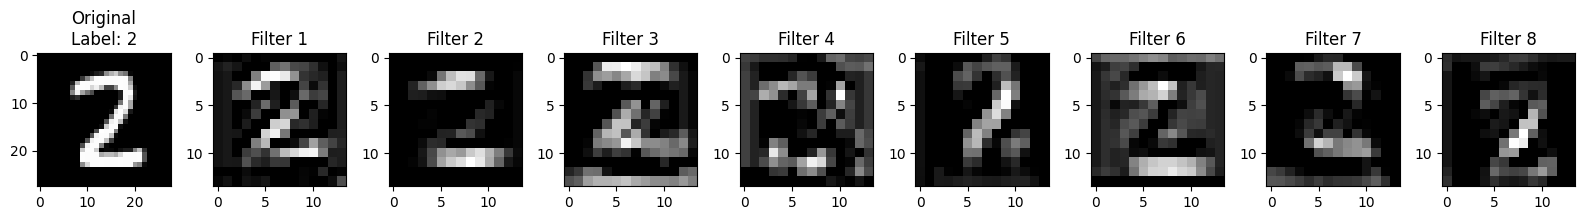

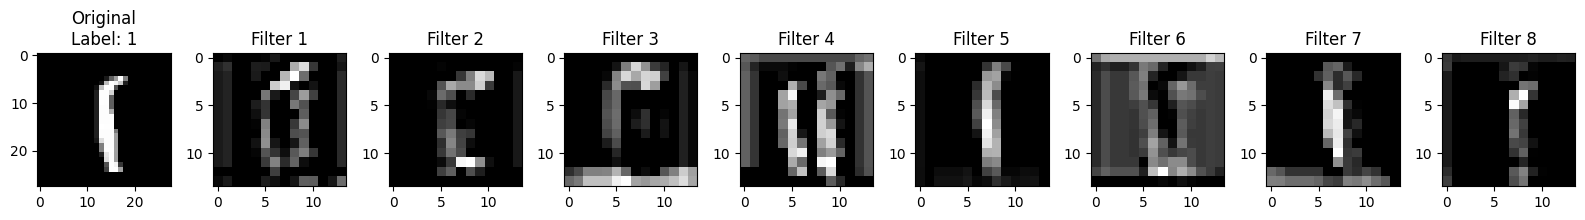

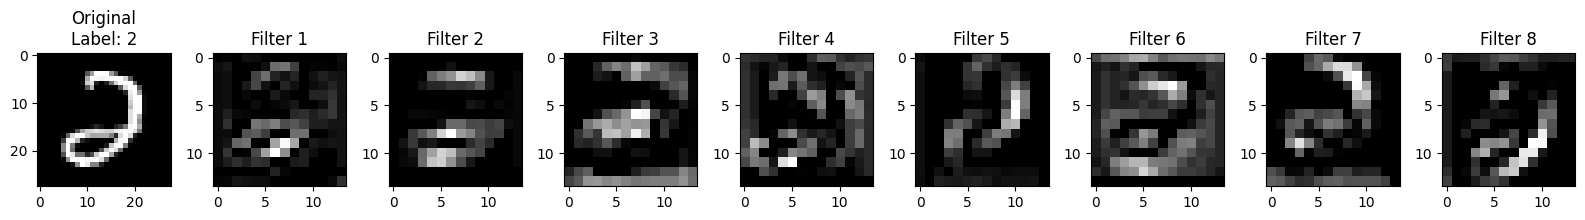

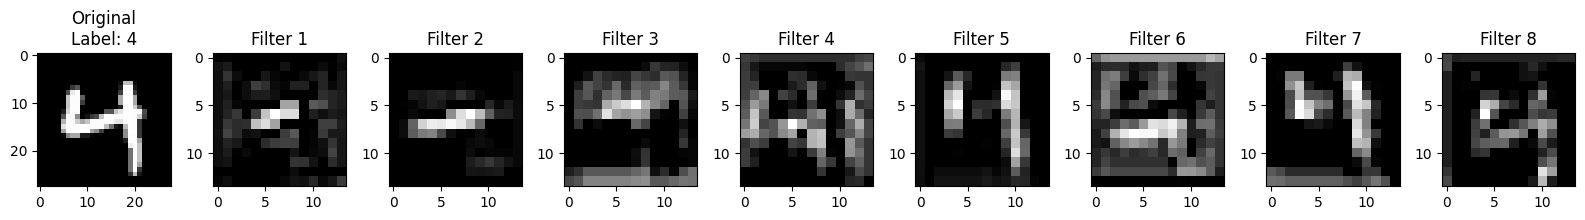

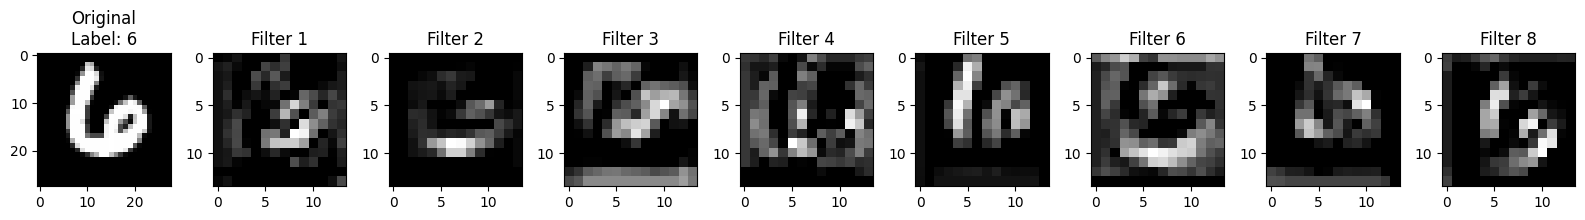

In [ ]:
input_images = random_images_stacked.unsqueeze(1) if len(random_images_stacked.shape) == 3 else random_images_stacked
activations = model.conv1(input_images)
activations = activations.detach().cpu().numpy()

for i in range(len(random_images)):  # Loop over all images
    plt.figure(figsize=(30, 6))

    # Original image
    plt.subplot(1, 17, 1)
    plt.imshow(random_images[i].squeeze(), cmap='gray')
    plt.title(f"Original\nLabel: {random_labels[i]}")

    for j in range(8):
        plt.subplot(1, 17, j+2)
        plt.imshow(activations[i, j, :, :], cmap='gray')
        plt.title(f"Filter {j+1}")

    plt.tight_layout()
    plt.show()

1. **Purpose and Insights**: The Deep Dream technique is a creative way to understand the learned features of CNN filters. In essence, an initially random noise image is tuned in such a way that it maximally activates a given filter of the CNN. For instance, if the filter detects Bananas in an image, the optimization algorithm will likely tune the image to resemble a banana as shown in the image below:

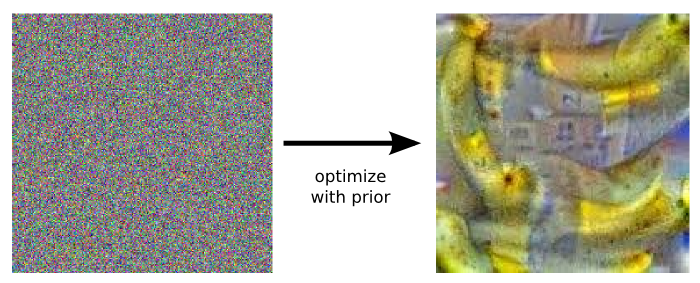


2. **Technical Details**: The `deep_dream_with_adam` function generates a 'dreamed' image by iteratively enhancing the activation of a chosen filter within the first convolutional layer. This is achieved through the following steps:
   - A base image, initially a random noise image, is cloned and set to require gradients.
   - An optimizer is used to adjust the image based on the gradient information.
   - In each iteration, the image is passed through the first convolutional layer, and the activation of the specified filter (channel) is isolated.
   - The mean of this activation is used as a loss, which is then maximized (negative mean) to enhance the features that the filter responds to.
   - Backpropagation is applied to adjust the image pixels, amplifying the features that activate the chosen filter.

3. **Visualization**: After generating the dreamed images for different filters, each image is unnormalized and plotted



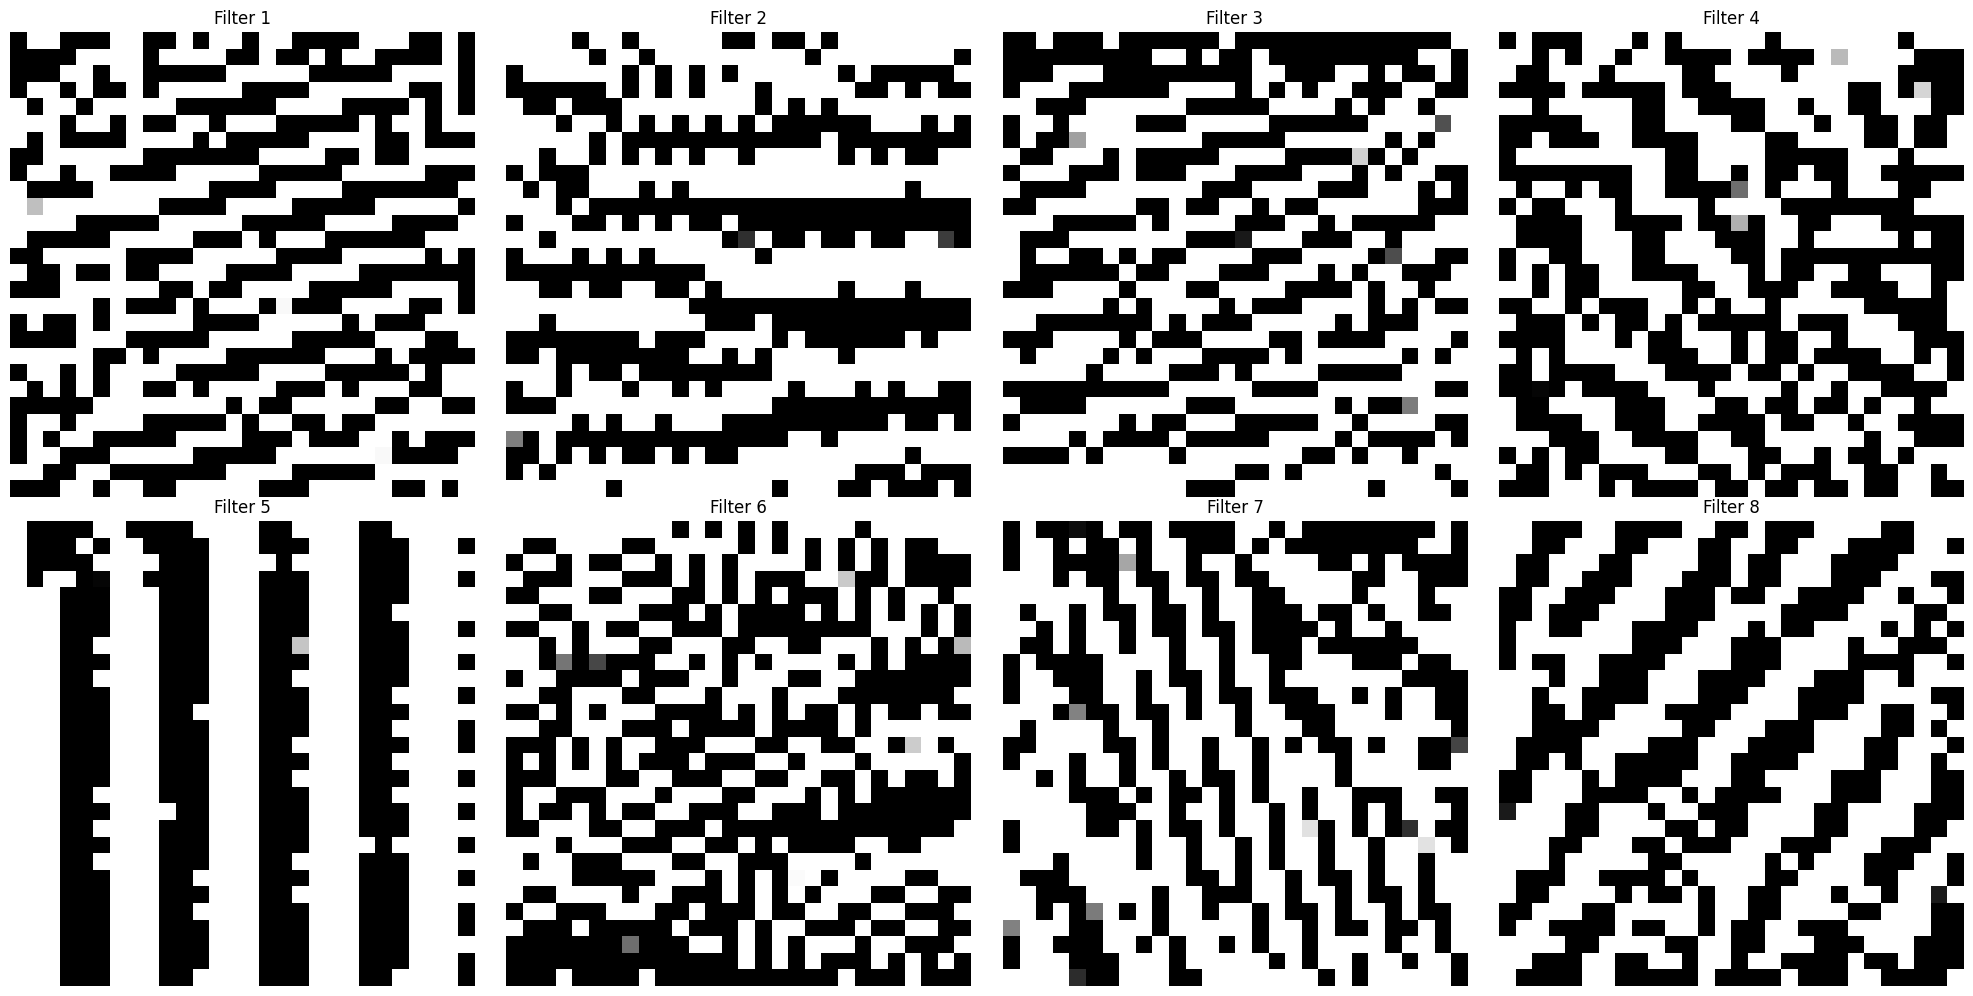

In [ ]:

import torch.optim as optim

def deep_dream_with_adam(model, base_image, channel, iterations=2000, lr=0.01):
    dreamed_image = base_image.clone().requires_grad_(True)
    optimizer = optim.Adam([dreamed_image], lr=lr)

    for i in range(iterations):
        optimizer.zero_grad()
        x1 = model.conv1(dreamed_image)
        target = x1[0, channel]
        loss = -target.mean()
        loss.backward()
        optimizer.step()

    return dreamed_image.detach()

def unnormalize(img, mean, std):
    return img * std + mean


mean = 0.5
std = 0.5

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

seed_value = 42
torch.manual_seed(seed_value)

base_image = torch.randn(1, 1, 28, 28, device='cuda' if torch.cuda.is_available() else 'cpu')
n_channels = 8
n_rows = 2

fig, axes = plt.subplots(n_rows, 4, figsize=(20, 10))  # Adjust the figure size as needed

for channel in range(n_channels):
    # Perform deep dream
    dreamed_image = deep_dream_with_adam(model, base_image, channel)

    # Unnormalize the image
    dreamed_image_unnorm = unnormalize(dreamed_image, mean, std)

    # Move to CPU and convert to NumPy for visualization
    dreamed_image_np = dreamed_image_unnorm.cpu().numpy().squeeze()

    # Ensure the image is within [0, 1] after unnormalization
    dreamed_image_np = np.clip(dreamed_image_np, 0, 1)

    # Find the row and column to place the current image
    row = channel // 4  # Integer division to find the row index
    col = channel % 4   # Modulus to find the column index

    # Visualize on the appropriate subplot
    ax = axes[row, col]
    ax.imshow(dreamed_image_np, cmap='gray')
    ax.set_title(f'Filter {channel + 1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Next, we present our novel method called Gradient-Activated maps (GAM). GAM method is a technique for analyzing the influence of specific image regions on filter activations in a Convolutional Neural Network (CNN). This method combines a forward pass through the network's first convolutional layer with backpropagation to calculate gradients. These gradients are visualized as heatmaps, highlighting areas of the input image that most significantly activate each filter. The purpose of GAM is to offer a focused, computationally efficient insight into the functionalities of individual filters, revealing how they respond to particular features in the image.

Firt, we display an MNIST image as a base-line for comparison

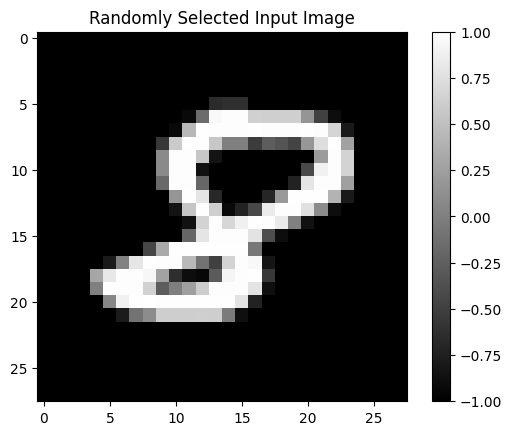

In [ ]:
from torch.autograd import Variable
import matplotlib.pyplot as plt

# Choose a random image from the random_images_stacked tensor
# Verwenden Sie einen festen Index anstelle eines zufälligen
fixed_idx = 61  # oder einen beliebigen anderen Index innerhalb des gültigen Bereichs
input_image  = test_dataset[fixed_idx][0].unsqueeze(0)

# Enable gradient tracking
input_image.requires_grad_()

# Plot the input image
plt.imshow(input_image[0][0].detach().numpy(), cmap='gray')
plt.title('Selected Input Image')
plt.colorbar()
plt.show()



The code uses Gradient-Activated Maps (GAM) to analyze how specific filters in a CNN's convolutional layer respond to an input image. Here's a concise summary focusing on the gradient computation:

1. **Forward Pass**: The code performs a forward pass through the CNN's first convolutional layer with an input image, generating a set of feature maps, each corresponding to a filter's output.

2. **Gradient Computation**: The key mathematical process involves calculating the Jacobian matrix for each filter's output. For each filter:
   - The code computes the mean of its feature map, reducing it to a scalar value.
   - It then calculates the gradient of this scalar with respect to the input image. This gradient is essentially the Jacobian matrix, representing how changes in each pixel of the input influence the mean activation of the filter.

3. **Visualization**: The resulting Jacobian matrix for each filter is visualized as a heatmap. These heatmaps highlight the regions in the input image that most significantly affect each filter's activation, offering insights into the features that each filter is detecting.


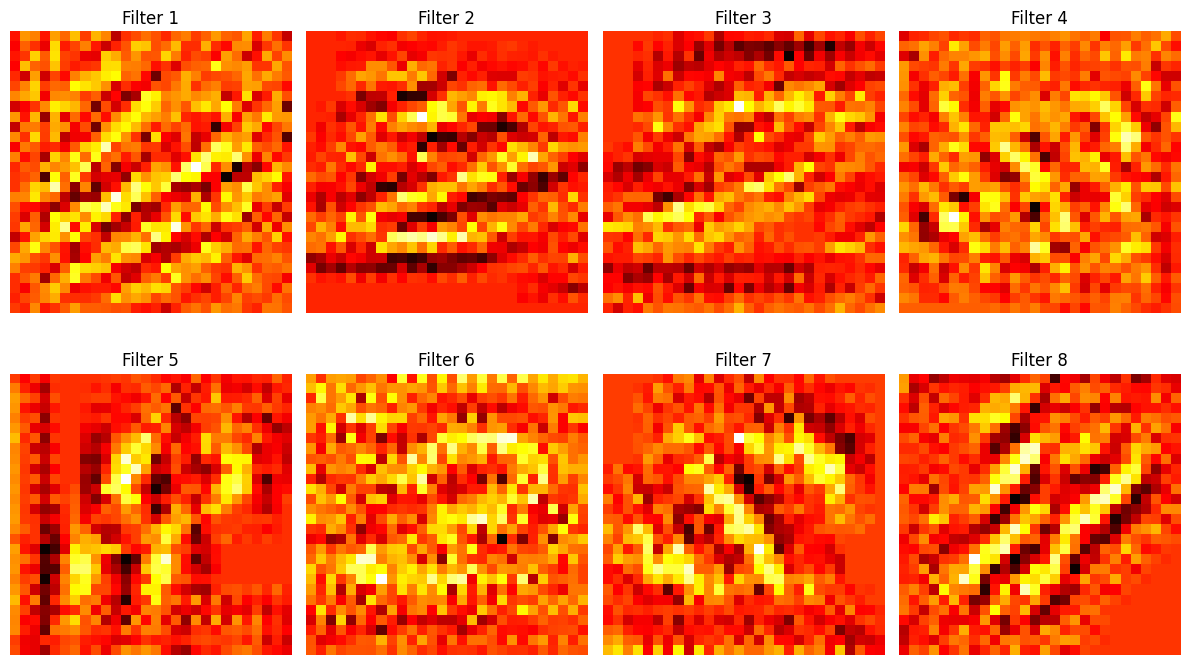

In [ ]:
# Forward pass to get the output of the first convolutional layer
conv1_output = model.conv1(input_image)

# Anzahl der Filter in der ersten konvolutionellen Schicht
num_filters = conv1_output.shape[1]

# Plot-Einstellungen
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12,10))

for i in range(num_filters):
    # Wähle den Ausgang des i-ten Filters
    single_filter_output = conv1_output[:, i, :, :]
    # Setze bestehende Gradienten zurück
    input_image.grad = None

    # Berechne den Gradienten des Ausgangs des i-ten Filters bezüglich des Eingabebildes
    single_filter_output.mean().backward(retain_graph=True)

    # Extrahiere und visualisiere die Gradienten
    grad = input_image.grad[0].cpu().detach().numpy()
    row = i // 4
    col = i % 4
    axes[row, col].imshow(grad[0], cmap='hot')
    axes[row, col].set_title(f'Filter {i+1}')
    axes[row, col].axis('off')
plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(wspace=10)

plt.tight_layout()
plt.show()

As a summary we study the strengths and weaknesses of each presented method:

1. **Weight Visualization**: Provides a basic understanding of what a filter is doing but it doesn’t reveal how these filters respond to actual input data.

2. **Filter Response Visualization**: Reveals how filters respond to actual data but as we go deeper into the CNN, the filters become more abstract and their visualizations less interpretable and harder to visualize.

3. **Deep Dream**: DeepDream provides an intuititive understanding of the filters however and its artistic nature might overemphasize or exaggerate certain aspects.

4. **Gradient-Activated Maps (GAM)**:  GAM provides a focused understanding of the relationship between parts of the input image and individual filter activations. Moreover, note that the higher layers are closer to the final output of the network and thus play a more direct role in the decision-making process. By using GAM in these layers, it’s possible to gain insights into which features are most influential in the network’s classifications or predictions. However, the interpretation of gradients can be misleading: High gradient values might indicate important areas for a filter's activation, but they don't indicate why a particular area is important.

**Limitations**: Despite these techniques, it's important to acknowledge the inherent complexity of large neural networks. While we may not be able to fully understand every aspect of these sophisticated models, the combination of these visualization techniques allows us to gain partial insights into their functioning. These insights can guide us in improving the network's design, troubleshooting issues, and making more informed decisions in applying these models.